# Pylops - Least squares image-domain migration - marmousi model

### Author: M.Ravasi

In this notebook we show how to use the ``Kirchhoff`` module to perform image-domain least-squares migration

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from numba import jit

from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

parallel=False

## 2D Marmousi

Lets' create a model and geometry

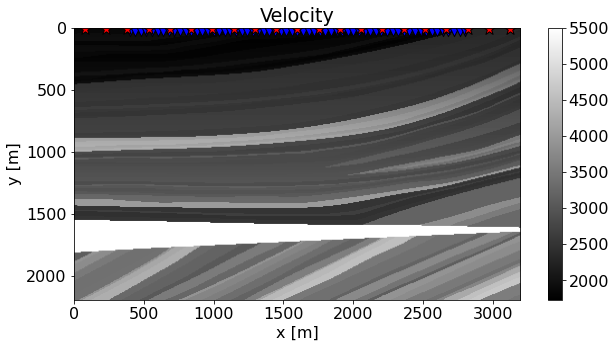

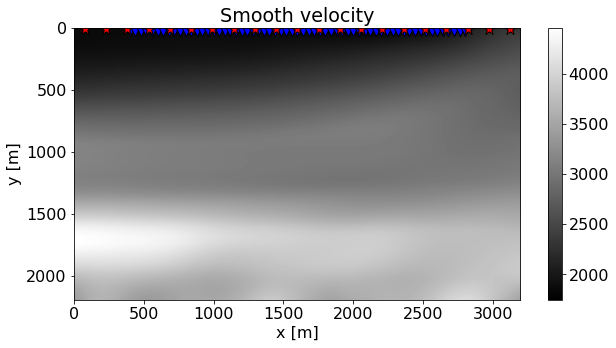

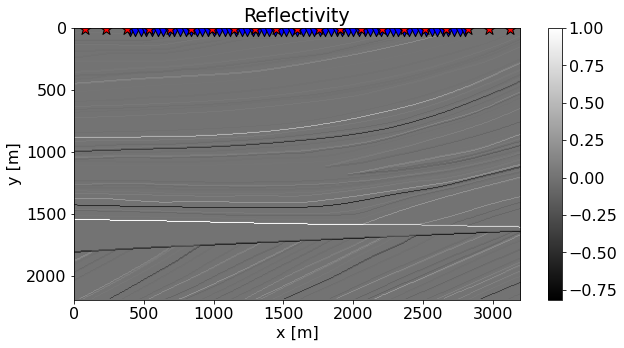

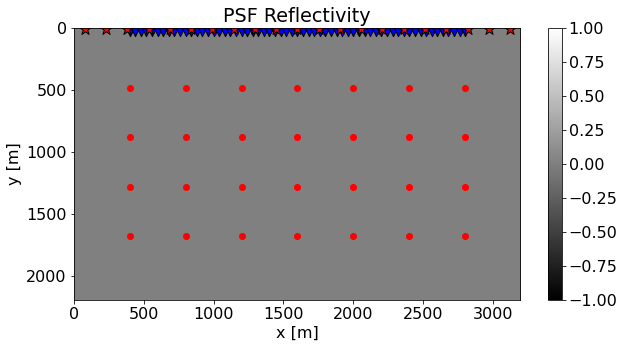

In [2]:
#Velocity
inputfile='../../pylops/testdata/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, vel_true = model['x'] - model['x'][0], model['z'] - model['z'][0], 1000*model['model'].T
x, z, vel_true = x[::2], z[::2], vel_true[::2, ::2]
nx, nz = len(x), len(z)
dx, dz = x[1]-x[0], z[1]-z[0]

# Reflectivity
refl = np.diff(vel_true, axis=1)
refl = np.hstack([refl, np.zeros((nx, 1))])
refl = refl/refl.max()

# PSF Model
psfrefl = np.zeros((nx, nz))
psfin = (50, 60)
psfend = (-49, -49)
psfj = (50, 50)
psfsize = (31, 31)
psfrefl[psfin[0]:psfend[0]:psfj[0], psfin[1]:psfend[-1]:psfj[-1]] = 1

#psf grid
psfx = np.arange(psfin[0], nx+psfend[0], psfj[0])
psfz = np.arange(psfin[1], nz+psfend[1], psfj[1])
Psfx, Psfz = np.meshgrid(psfx, psfz, indexing='ij')

# Smooth velocity
nsmooth=50
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel, axis=1)

# Receivers
nr = 61
rx = np.linspace(dx*50, (nx-50)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 21
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(psfrefl.T, cmap='gray', vmin=-1, vmax=1, extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(Psfx.ravel()*dx, Psfz.ravel()*dz, c='r')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('PSF Reflectivity')
plt.xlim(x[0], x[-1]);

### Dataset creation and migration

In [3]:
nt = 601
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

kop = Kirchhoff(z, x, t, sources, recs, vel, wav, wavc, mode='eikonal', 
                dynamic=False, wavfilter=True, engine='numba')
kopdyn = Kirchhoff(z, x, t, sources, recs, vel, wav, wavc, mode='eikonal', 
                   dynamic=True, wavfilter=True, aperture=2, angleaperture=50, engine='numba')

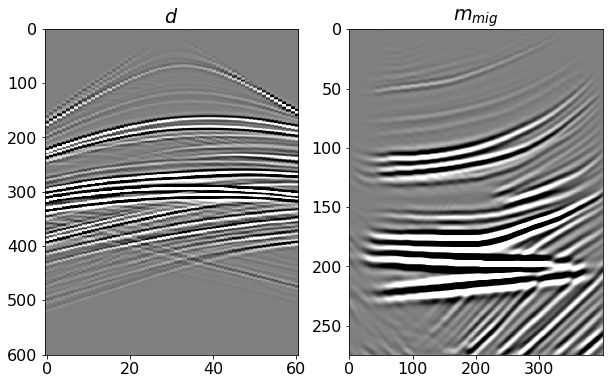

In [4]:
d = kop * refl.ravel()
d = d.reshape(ns, nr, nt)

mmig = kopdyn.H * d.ravel()
mmig = mmig.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(d[ns//2, :, :].T, cmap='gray', vmin=-1e3, vmax=1e3, interpolation='none')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(mmig.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{mig}$')
axs[1].axis('tight');

### PSF creation and migration

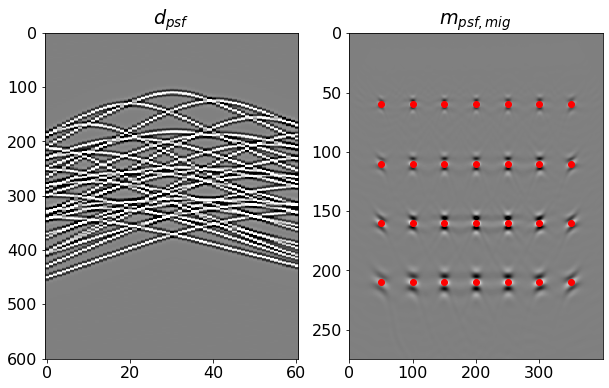

In [5]:
dpsf = kop * psfrefl.ravel()
dpsf = dpsf.reshape(ns, nr, nt)

mmigpsf = kopdyn.H * dpsf.ravel()
mmigpsf = mmigpsf.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(dpsf[ns//2, :, :].T, cmap='gray', vmin=-1e2, vmax=1e2, interpolation='none')
axs[0].set_title(r'$d_{psf}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf.T, cmap='gray', vmin=-4, vmax=4)
axs[1].scatter(Psfx.ravel(), Psfz.ravel(), c='r')
axs[1].set_title(r'$m_{psf,mig}$')
axs[1].axis('tight');

### Image domain LSM

First, we extract the different PSFs

In [6]:
psfs = np.zeros((len(psfx), len(psfz), *psfsize))

for ipx, px in enumerate(psfx):
    for ipz, pz in enumerate(psfz):
        psfs[ipx, ipz] = mmigpsf[int(px-psfsize[0]//2):int(px+psfsize[0]//2+1), 
                                 int(pz-psfsize[1]//2):int(pz+psfsize[1]//2+1)] 

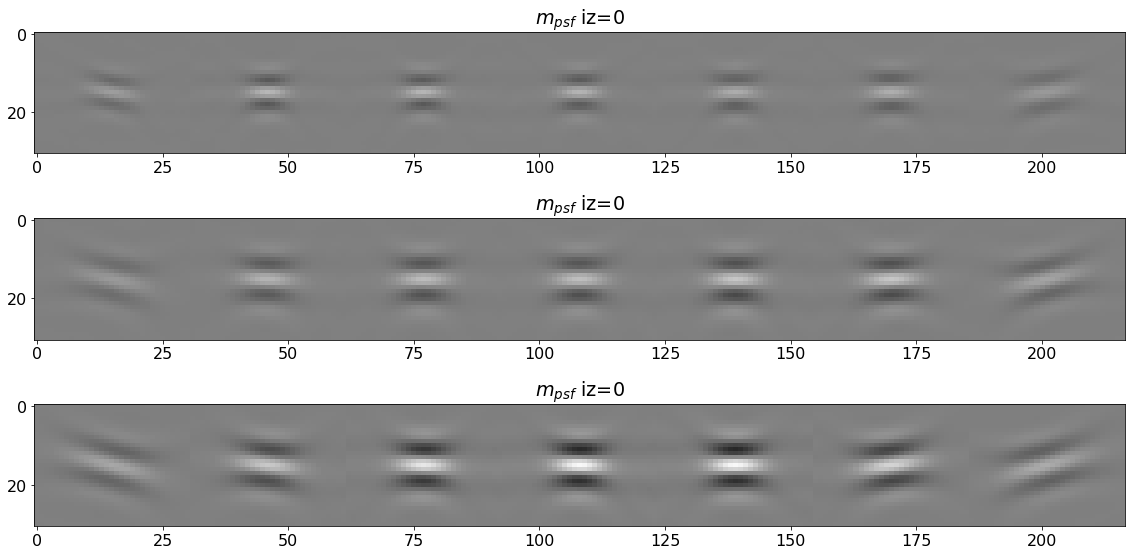

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(16, 8))
axs[0].imshow(psfs[:, 0].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[0].set_title(r'$m_{psf}$ iz=0')
axs[0].axis('tight')
axs[1].imshow(psfs[:, 1].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{psf}$ iz=0')
axs[1].axis('tight')
axs[2].imshow(psfs[:, 2].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[2].set_title(r'$m_{psf}$ iz=0')
axs[2].axis('tight')
plt.tight_layout()

In [8]:
@jit(nopython=True, parallel=parallel, nogil=True)
def matvec(x, y, psfs, psfshape, xdims, opsfx, opsfz, dpsfx, dpsfz, npsfx, npsfz):
    for ix in range(xdims[0]):
        for iz in range(xdims[1]):
            # find and interpolate psf (for now using only 2 nearby horizontally)
            ipsfx_closest = int(np.floor((ix - opsfx) / dpsfx))
            ipsfz_closest = int(np.round((iz - opsfz) / dpsfz))
            if ipsfz_closest >= npsfz:
                ipsfz_closest = npsfz-1
            if ipsfx_closest < 0:
                psf = psfs[0, ipsfz_closest]
            elif ipsfx_closest >= npsfx-1:
                psf = psfs[npsfx-1, ipsfz_closest]
            else:
                dpsfx_closest = (ix - opsfx) / dpsfx - ipsfx_closest
                psf = (1 - dpsfx_closest) * psfs[ipsfx_closest, ipsfz_closest] + \
                        dpsfx_closest * psfs[ipsfx_closest + 1, ipsfz_closest]
            xextremes = (max(0, ix-psfshape[0]//2), min(ix+psfshape[0]//2+1, xdims[0]))
            zextremes = (max(0, iz-psfshape[1]//2), min(iz+psfshape[1]//2+1, xdims[1]))
            psfxextremes = (max(0, -ix+psfshape[0]//2), 
                            min(psfshape[0], psfshape[0]//2 + (xdims[0]-ix)))
            psfzextremes = (max(0, -iz+psfshape[1]//2), 
                            min(psfshape[1], psfshape[1]//2 + (xdims[1]-iz)))
            y[xextremes[0]:xextremes[1], zextremes[0]:zextremes[1]] += x[ix, iz] * \
                psf[psfxextremes[0]:psfxextremes[1], psfzextremes[0]:psfzextremes[1]]
    return y.ravel()

@jit(nopython=True, parallel=parallel, nogil=True)
def rmatvec(x, y, psfs, psfshape, xdims, opsfx, opsfz, dpsfx, dpsfz, npsfx, npsfz):
    for ix in range(xdims[0]):
        for iz in range(xdims[1]):
            # find and interpolate psf (for now using only 2 nearby horizontally)
            ipsfx_closest = int(np.floor((ix - opsfx) / dpsfx))
            ipsfz_closest = int(np.round((iz - opsfz) / dpsfz))
            if ipsfz_closest >= npsfz:
                ipsfz_closest = npsfz-1
            if ipsfx_closest < 0:
                psf = psfs[0, ipsfz_closest]
            elif ipsfx_closest >= npsfx-1:
                psf = psfs[npsfx-1, ipsfz_closest]
            else:
                dpsfx_closest = (ix - opsfx) / dpsfx - ipsfx_closest
                psf = (1 - dpsfx_closest) * psfs[ipsfx_closest, ipsfz_closest] + \
                        dpsfx_closest * psfs[ipsfx_closest + 1, ipsfz_closest]
            xextremes = (max(0, ix-psfshape[0]//2), min(ix+psfshape[0]//2+1, xdims[0]))
            zextremes = (max(0, iz-psfshape[1]//2), min(iz+psfshape[1]//2+1, xdims[1]))
            psfxextremes = (max(0, -ix+psfshape[0]//2), 
                            min(psfshape[0], psfshape[0]//2 + (xdims[0]-ix)))
            psfzextremes = (max(0, -iz+psfshape[1]//2), 
                            min(psfshape[1], psfshape[1]//2 + (xdims[1]-iz)))
            y[ix, iz] = np.sum(psf[psfxextremes[0]:psfxextremes[1], psfzextremes[0]:psfzextremes[1]] * \
                x[xextremes[0]:xextremes[1], zextremes[0]:zextremes[1]])
    return y.ravel()


class Con2Dnonstat(LinearOperator):
    def __init__(self, psf, ipsfx, ipsfz, xdims, dtype='float64'):
        self.psf = psf
        self.psfshape = psf.shape[2:]
        self.opsfx, self.dpsfx, self.npsfx = ipsfx[0], ipsfx[1]-ipsfx[0], len(ipsfx)
        self.opsfz, self.dpsfz, self.npsfz = ipsfz[0], ipsfz[1]-ipsfz[0], len(ipsfz)
        self.epsfx, self.epsfz = ipsfx[-1], ipsfz[-1]
        self.xdims = xdims
        self.shape = (np.prod(xdims), np.prod(xdims))
        self.dtype = dtype
        self.matvec_count, self.rmatvec_count = 0,0
    
    def _matvec(self, x):
        x = x.reshape(self.xdims)
        y = np.zeros(self.xdims)
        y = matvec(x, y, self.psf, self.psfshape, self.xdims, 
                   self.opsfx, self.opsfz, self.dpsfx, 
                   self.dpsfz, self.npsfx, self.npsfz)
        return y.ravel()
                        
    def _rmatvec(self, x):
        x = x.reshape(self.xdims)
        y = np.zeros(self.xdims)
        y = rmatvec(x, y, self.psf, self.psfshape, self.xdims, 
                    self.opsfx, self.opsfz, self.dpsfx, 
                    self.dpsfz, self.npsfx, self.npsfz)
        return y.ravel()

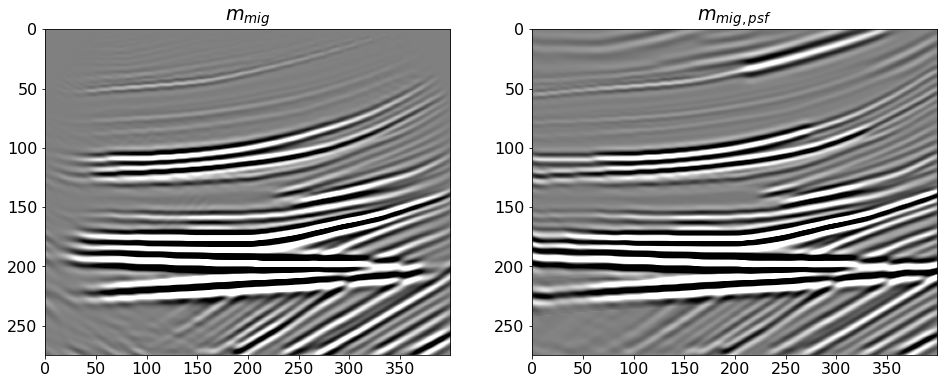

In [9]:
Cop = Con2Dnonstat(psfs, psfx, psfz, (nx, nz))

mmigpsf = Cop * refl.ravel()
mmigpsf = mmigpsf.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight');

In [10]:
dottest(Cop, verb=True, raiseerror=False);

Dot test passed, v^H(Opu)=7078.223107635434 - u^H(Op^Hv)=7078.22310763543


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 110000 rows and 110000 cols
eps = 1.000000e+02	tol = 1.000000e-10	niter = 200
alpha = 3.188288e-06	thresh = 1.594144e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         1.925e+06   1.990e+06   5.019e+00
     2       0.0000e+00         1.177e+06   1.266e+06   1.712e+00
     3       0.0000e+00         7.734e+05   8.838e+05   1.397e+00
     4       0.0000e+00         5.366e+05   6.643e+05   1.184e+00
     5       0.0000e+00         3.905e+05   5.328e+05   1.018e+00
     6       0.0000e+00         2.965e+05   4.512e+05   8.845e-01
     7       0.0000e+00         2.334e+05   3.986e+05   7.760e-01
     8       0.0000e+00         1.892e+05   3.632e+05   6.888e-01
     9       0.0000e+00         1.568e+05   3.382e+05   6.193e-01
    10      

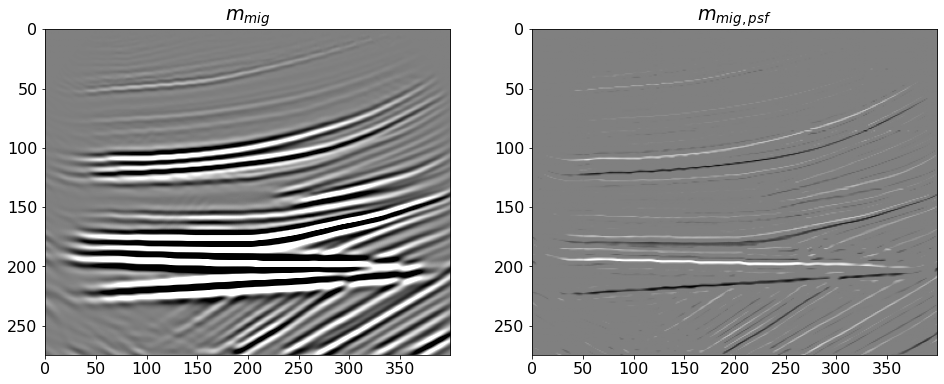

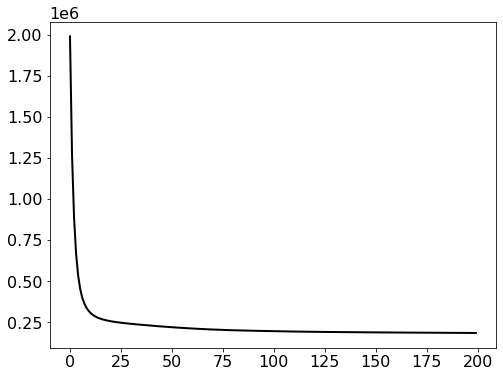

In [11]:
reflinv, _, resnorm = fista(Cop, mmig.ravel(), eps=1e2, niter=200, 
                            eigsdict=dict(niter=5, tol=1e-2), show=True)
reflinv = reflinv.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(reflinv.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')

plt.figure()
plt.plot(resnorm, 'k', lw=2);

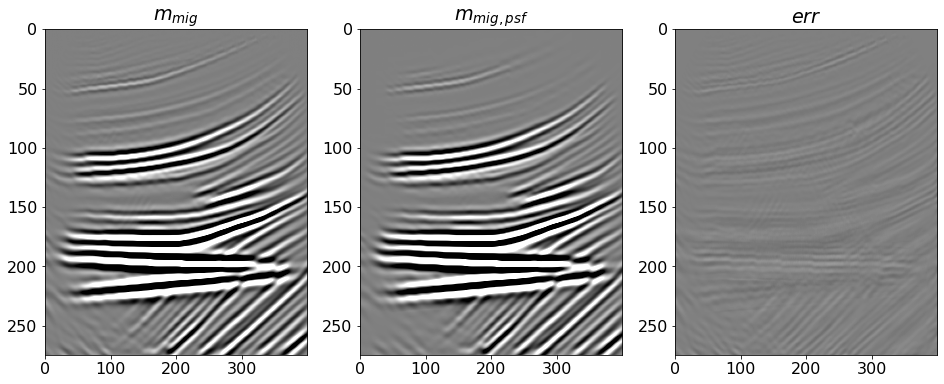

In [12]:
dinv = Cop @ reflinv.ravel()
dinv = dinv.reshape(nx, nz)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(dinv.T, cmap='gray', vmin=-10, vmax=10)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight')
axs[2].imshow(mmig.T-dinv.T, cmap='gray', vmin=-10, vmax=10)
axs[2].set_title(r'$err$')
axs[2].axis('tight');

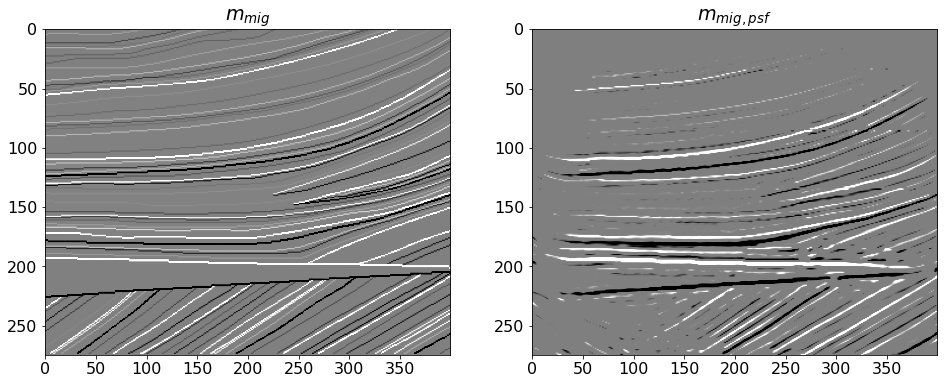

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(refl.T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(reflinv.T, cmap='gray', vmin=-1e-1, vmax=1e-1)
axs[1].set_title(r'$m_{mig, psf}$')
axs[1].axis('tight');